In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import norm
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from py_vollib import black_scholes as bs

# Generate the Option

***Assumptions of generating basket option pricing data:***
  
Number of assets: 2  
Initial stock price: 30 - 70  
Strike price: 10 - 90  
Intreast rate: 0.01 - 0.03  
Volatility of each asset: 0.15 - 0.6  
Correlation between two assets: 0.05 - 0.7  
Weight of two assets: 0.5, 0.5  
Time to Maturity: 3-, 6-, 9- and 12-month

In [14]:
# Setup the grid for data generation
S_0 = uniform.ppf(pd.Series(np.linspace(0.01, 0.99, 6)), 30, 40)  # Initial spot price
K = uniform.ppf(pd.Series(np.linspace(0.01, 0.99, 6)), 10, 80)    # Strike price
r = uniform.ppf(pd.Series(np.linspace(0.01, 0.99, 6)), 0.01, 0.02) # Risk-free rate
sigma1 = uniform.ppf(pd.Series(np.linspace(0.01, 0.99, 6)), 0.15, 0.6) # Volatility of Asset 1
sigma2 = uniform.ppf(pd.Series(np.linspace(0.01, 0.99, 6)), 0.15, 0.6) # Volatility of Asset 2
rho = uniform.ppf(pd.Series(np.linspace(0.01, 0.99, 6)), 0.05, 0.65)   # Correlation between two assets
T = np.array([0.25, 0.5, 0.75, 1])  # Time to maturity

grid = ParameterGrid({'S_0': S_0, 'K': K, 'r': r, 'sigma1': sigma1, 'sigma2': sigma2, 'rho': rho, 'T': T})

# Generate option prices using B-S equation and moment matching method
option_data = []
for params in tqdm(grid):
    try:
        K, S_0, T, r, rho, sigma1, sigma2 = params.values()
        S = np.array([S_0, S_0])
        sigma = np.array([sigma1, sigma2])
        Eta = np.array([[1, rho], [rho, 1]])
        mod_sigma = sigma.dot(Eta).dot(sigma) / len(sigma) ** 2
        forward = np.product(S) ** (1 / len(sigma))
        d_1 = (np.log(forward / K) + 0.5 * mod_sigma * T) / np.sqrt(mod_sigma * T)
        d_2 = d_1 - np.sqrt(mod_sigma * T)
        price = forward * norm.cdf(d_1) - K * norm.cdf(d_2)
        params['price'] = price
        option_data.append(params)
    except Exception as e:
        print(f"Error processing parameters {params}: {e}")

option_df = pd.DataFrame(option_data)
option_df

100%|██████████| 186624/186624 [00:37<00:00, 4951.38it/s]


,K,S_0,T,r,rho,sigma1,sigma2,price
0,10.8,30.4,0.25,0.0102,0.0565,0.156,0.1560,19.600000
1,10.8,30.4,0.25,0.0102,0.0565,0.156,0.2736,19.600000
2,10.8,30.4,0.25,0.0102,0.0565,0.156,0.3912,19.600000
3,10.8,30.4,0.25,0.0102,0.0565,0.156,0.5088,19.600000
4,10.8,30.4,0.25,0.0102,0.0565,0.156,0.6264,19.600000
...,...,...,...,...,...,...,...,...
186619,89.2,69.6,1.00,0.0298,0.6935,0.744,0.2736,7.102493
186620,89.2,69.6,1.00,0.0298,0.6935,0.744,0.3912,8.441425
186621,89.2,69.6,1.00,0.0298,0.6935,0.744,0.5088,9.847066
186622,89.2,69.6,1.00,0.0298,0.6935,0.744,0.6264,11.301328


# Neural Network Model

In [38]:
"""Construct the neural network (NN) model"""
def NN_model():
    input_layer = Input(shape=(7,))  # Define the input layer with 7 nodes (S, K, r, T, rho, sigma1, sigma2)
    first_hidden = Dense(10, activation='relu')(input_layer)   # First hidden layer with 10 nodes
    second_hidden = Dense(10, activation='relu')(first_hidden)   # Second hidden layer with 10 nodes
    output_layer = Dense(1)(second_hidden)   # Output layer
    model = Model(input_layer, output_layer)   # Construct model
    model.compile(loss="mse", optimizer= "adam")
    return model

In [39]:
"""Train and test the NN model"""
model = NN_model()
X = option_df[['S_0', 'K', 'r', 'T', 'rho', 'sigma1', 'sigma2']]   # Seven input nodes
y = option_df[['price']]   # Output node

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)   # Split train and test sample
early_stopping = EarlyStopping(monitor='val_loss', patience=10)   # Set the early stop condition
train = model.fit(X_train, y_train, batch_size = 64, epochs = 100, verbose = 0, validation_split=0.2, callbacks=[early_stopping])   # Train the model
test = model.evaluate(X_test, y_test)   # Test the model

584/584 [==============================] - 1s 2ms/step - loss: 0.1399


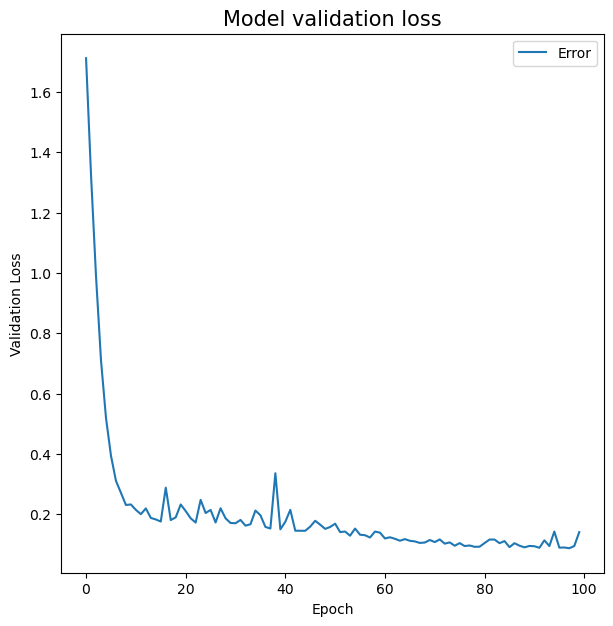

In [40]:
"""Plot of the Validation Loss"""
plt.figure(figsize=(7,7))
plt.plot(train.history['val_loss'])
plt.title('Model validation loss', fontsize=15)
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Error'], loc='upper right')
plt.show()

584/584 [==============================] - 1s 1ms/step


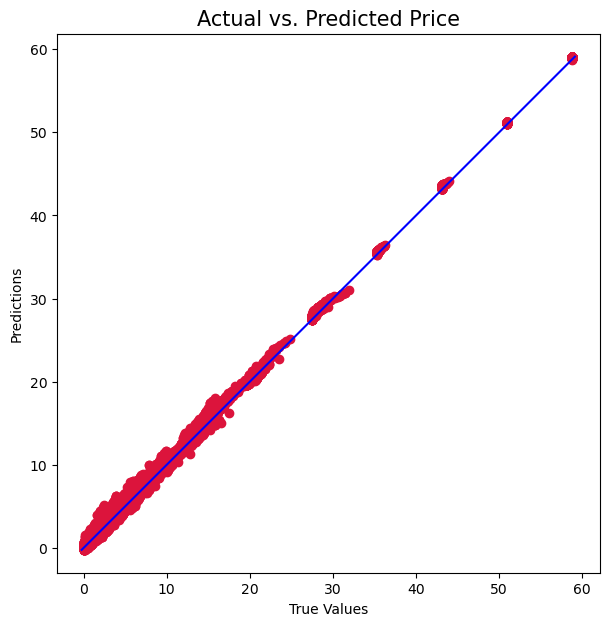

In [41]:
"""Plot of the Actual vs. True"""
y_pred = model.predict(X_test)
y_t = y_test['price']

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_t))
p2 = min(min(y_pred), min(y_t))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Actual vs. Predicted Price', fontsize=15)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()

In [25]:
"""Function for predicting option price using our trained NN model"""
def nn_predict(S_0, K, r, T, rho, sigma1, sigma2):
    res = model.predict(np.array([S_0, K, r, T, rho, sigma1, sigma2]).reshape(1,-1), verbose = 0)
    return res[0][0]

# Monte-Carlo Simulation

In [42]:
"""Setup the Monte-Carlo simulation"""
def mc_predict(S_0, K, r, T, rho, sigma1, sigma2, w, n):
    mu = [0.03]   # Drift rate
    if n == 1: 
        weight = [1]
        sigma = [sigma1]
        Eta = np.array([[1]])
    else:
        weight = [w, 1-w]   # Weight of each asset
        sigma = [sigma1, sigma2]   # Sigma of each asset
        Eta = np.array([[1, rho], [rho, 1]])   # Correlation Matrix
    L = np.linalg.cholesky(Eta)   # Cholesky Decomposation
    N = 3*10**7   # Number of simulations

    np.random.seed(0)
    S = S_0*np.exp((np.diag(mu) - 1/2 * np.diag(sigma)**2) @ (np.ones((n, N)) * T) + np.diag(sigma) @ np.matmul(np.sqrt(T) * L, np.random.normal(0, 1, (n, N)))) # Simulate strike price
    payoff = np.matmul(weight, S)-K   # Payoffs
    payoff = np.sum(payoff[(payoff >= 0)]) / N  # Average of Max(Payoff, 0)
    V = np.exp(-r * T) * payoff   # Option price
    
    return V

# Two-asset Situation Comparison

In this section, I compare the basket option prices of neural network model and the Monte-Carlo simulation using two assets.

In [48]:
"""Setup Option Information"""
test_df = pd.DataFrame()
np.random.seed(9985125)

alpha = 0.5   # Weight
# Random initial spot price with alpha equals 0.5
S_0_1 = np.random.uniform(40, 60, 100)
S_0_2 = np.random.uniform(40, 60, 100)
test_df['S_0'] = S_0_1 * alpha + S_0_2 * (1 - alpha)

# Random strike price
test_df['K'] = np.random.uniform(30, 70, 100)

# Random sigma of each asset
test_df['sigma1'] = np.random.uniform(0.15, 0.2, 100)
test_df['sigma2'] = np.random.uniform(0.4, 0.5, 100)

test_df['rho'] = np.random.uniform(0.1, 0.6, 100)   # Random correlation
test_df['r'] = np.random.uniform(0.01, 0.03, 100)   # Random risk-free rates
test_df['T']  = np.random.choice([0.25, 0.5, 0.75, 1], 100)   # Random time to maturity
test_df

,S_0,K,sigma1,sigma2,rho,r,T
0,57.287135,57.791838,0.199025,0.417990,0.167562,0.023008,1.00
1,47.791130,65.088369,0.164813,0.403290,0.208178,0.012237,1.00
2,55.819857,67.313955,0.153682,0.487578,0.303122,0.024853,0.75
3,50.018562,56.944130,0.177489,0.493483,0.118933,0.022429,0.50
4,55.408542,37.574481,0.151493,0.461509,0.396645,0.025520,0.50
...,...,...,...,...,...,...,...
95,55.233642,66.551660,0.159190,0.453062,0.136379,0.016254,0.75
96,48.258237,67.453168,0.168173,0.410085,0.551556,0.025459,1.00
97,53.247120,40.085274,0.156169,0.429338,0.436708,0.019085,0.75
98,54.414330,40.137295,0.163132,0.423852,0.258359,0.020314,0.75


In [49]:
nn_price = []
mc_price = []

for index, row in test_df.iterrows():
    S_0, K, sigma1, sigma2, rho, r, T = row   # Read basket option information
    nn_price.append(nn_predict(S_0, K, r, T, rho, sigma1, sigma2))   # Predict option price using the NN model
    mc_price.append(mc_predict(S_0, K, r, T, rho, sigma1, sigma2, alpha, 2)) # Predict option price using the Monte-Carlo Simulation

test_df['nn_price'] = nn_price
test_df['mc_price'] = mc_price
test_df

,S_0,K,sigma1,sigma2,rho,r,T,nn_price,mc_price
0,57.287135,57.791838,0.199025,0.417990,0.167562,0.023008,1.00,5.637567,7.234258
1,47.791130,65.088369,0.164813,0.403290,0.208178,0.012237,1.00,0.996196,1.103781
2,55.819857,67.313955,0.153682,0.487578,0.303122,0.024853,0.75,1.654827,2.651590
3,50.018562,56.944130,0.177489,0.493483,0.118933,0.022429,0.50,1.165370,2.056845
4,55.408542,37.574481,0.151493,0.461509,0.396645,0.025520,0.50,18.299488,19.294050
...,...,...,...,...,...,...,...,...,...
95,55.233642,66.551660,0.159190,0.453062,0.136379,0.016254,0.75,1.426733,2.185474
96,48.258237,67.453168,0.168173,0.410085,0.551556,0.025459,1.00,1.116131,1.231524
97,53.247120,40.085274,0.156169,0.429338,0.436708,0.019085,0.75,13.736486,15.636591
98,54.414330,40.137295,0.163132,0.423852,0.258359,0.020314,0.75,14.838741,16.674307


In [50]:
average_nn = test_df['nn_price'].mean()
average_mc = test_df['mc_price'].mean()
diff = abs((test_df['nn_price'] - test_df['mc_price']).mean())
mse = mean_squared_error(test_df['mc_price'], test_df['nn_price'])

print(f'The average predicted option price using the NN model is {average_nn:.2f}')
print(f'The average predicted option price using the Monte-Carlo simulation is {average_mc:.2f}')
print(f'The difference between these two methods is {diff:.2f}, and the MSE is {mse:.4f}')

The average predicted option price using the NN model is 7.34
The average predicted option price using the Monte-Carlo simulation is 8.26
The difference between these two methods is 0.92, and the MSE is 1.2758


# One-asset Situation Comparison

In [51]:
"""Setup Option Information"""
test_df = pd.DataFrame()
np.random.seed(75831)
test_df['S_0'] = np.random.uniform(40, 60, 100)   # Random initial price between $40-$60
test_df['K'] = np.random.randint(30, 70, 100)   #Random strike price between $30 - $70 (integers)
test_df['r'] = np.random.uniform(0.01, 0.03, 100)   # Random risk-free rates
test_df['Sigma'] = np.random.uniform(0.15, 0.5, 100)   # Random sigma
test_df['T']  = np.random.choice([0.25, 0.5, 0.75, 1], 100)   # Random time to maturity
test_df

,S_0,K,r,Sigma,T
0,56.664723,53,0.027426,0.346204,0.75
1,48.855382,66,0.018486,0.168004,1.00
2,48.466955,46,0.014724,0.351316,1.00
3,47.220134,57,0.013249,0.292095,0.50
4,48.133721,53,0.029845,0.437535,0.25
...,...,...,...,...,...
95,45.094570,51,0.027015,0.243579,0.50
96,45.718845,36,0.029731,0.327842,0.50
97,50.992005,43,0.024118,0.198527,0.75
98,53.079140,44,0.019952,0.307377,0.50


In [52]:
bs_price = []
nn_price = []
mc_price = []
flag = 'c'

for index, row in test_df.iterrows():
    S_0, K, r, sigma, T = row
    bs_price.append(bs.black_scholes(flag, S_0, K, T, r, sigma))
    nn_price.append(nn_predict(S_0, K, r, T, 1, sigma, sigma))
    mc_price.append(mc_predict(S_0, K, r, T, 1, sigma, sigma, 1, 1))

test_df['bs_price'] = bs_price
test_df['nn_price'] = nn_price
test_df['mc_price'] = mc_price
test_df

,S_0,K,r,Sigma,T,bs_price,nn_price,mc_price
0,56.664723,53,0.027426,0.346204,0.75,9.112562,9.060583,9.184136
1,48.855382,66,0.018486,0.168004,1.00,0.180839,0.929333,0.213990
2,48.466955,46,0.014724,0.351316,1.00,8.226069,8.916765,8.709459
3,47.220134,57,0.013249,0.292095,0.50,1.110367,1.137828,1.198874
4,48.133721,53,0.029845,0.437535,0.25,2.506375,2.850427,2.505886
...,...,...,...,...,...,...,...,...
95,45.094570,51,0.027015,0.243579,0.50,1.301766,1.147646,1.320717
96,45.718845,36,0.029731,0.327842,0.50,10.894057,10.279148,10.898903
97,50.992005,43,0.024118,0.198527,0.75,9.312512,9.414455,9.511445
98,53.079140,44,0.019952,0.307377,0.50,10.544598,10.377113,10.770647


In [54]:
average_bs = test_df['bs_price'].mean()
average_nn = test_df['nn_price'].mean()
average_mc = test_df['mc_price'].mean()
diff_bsnn = abs((test_df['nn_price'] - test_df['bs_price']).mean())
mse_bsnn = mean_squared_error(test_df['bs_price'], test_df['nn_price'])
diff_bsmc = abs((test_df['mc_price'] - test_df['bs_price']).mean())
mse_bsmc = mean_squared_error(test_df['bs_price'], test_df['mc_price'])
diff_mcnn = abs((test_df['nn_price'] - test_df['mc_price']).mean())
mse_mcnn = mean_squared_error(test_df['mc_price'], test_df['nn_price'])

print(f'The average predicted option price using the Black-Scholes model is {average_bs:.2f}')
print(f'The average predicted option price using the NN model is {average_nn:.2f}')
print(f'The average predicted option price using the Monte-Carlo simulation is {average_mc:.2f}')
print('\n')
print(f'The difference between the B-S model and the NN model is {diff_bsnn:.2f}, and the MSE is {mse_bsnn:.4f}')
print(f'The difference between the B-S model and the Monte-Carlo simulation is {diff_bsmc:.2f}, and the MSE is {mse_bsmc:.4f}')
print(f'The difference between the Monte-Carlo simulation and the NN model is {diff_mcnn:.2f}, and the MSE is {mse_mcnn:.4f}')

The average predicted option price using the Black-Scholes model is 8.38
The average predicted option price using the NN model is 8.58
The average predicted option price using the Monte-Carlo simulation is 8.59


The difference between the B-S model and the NN model is 0.19, and the MSE is 0.2017
The difference between the B-S model and the Monte-Carlo simulation is 0.21, and the MSE is 0.0951
The difference between the Monte-Carlo simulation and the NN model is 0.01, and the MSE is 0.1739
